In [ ]:
import torch

print("CUDA available", torch.cuda.is_available())
print("CUDA version", torch.version.cuda)
print("cuDNN enabled", torch.backends.cudnn.enabled)
print("cuDNN version", torch.backends.cudnn.version())

n_cuda_devices = torch.cuda.device_count()
for i in range(n_cuda_devices):
    print(f"Device {i} name:", torch.cuda.get_device_name(i))

CUDA available True
CUDA version 12.4
cuDNN enabled True
cuDNN version 90100
Device 0 name: NVIDIA GeForce MX450


In [ ]:
import numpy as np
import torch
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Step 1: Generate Synthetic Dataset
n_samples = 1000
n_features = 20
X, y = make_classification(
    n_samples=n_samples,
    n_features=n_features,
    n_informative=10,
    n_redundant=5,
    random_state=42,
)

# Split data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=42
)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

# Step 2: Initialize the TabNetClassifier
model = TabNetClassifier(
    n_d=8,
    n_a=8,
    n_steps=3,
    gamma=1.3,
    lambda_sparse=1e-3,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params={"step_size": 10, "gamma": 0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    mask_type="sparsemax",  # "entmax" or "sparsemax"
)

# Step 3: Train the TabNet Model
print("Starting training...")
model.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=["train", "valid"],
    eval_metric=["accuracy"],
    max_epochs=100,
    patience=10,
    batch_size=128,
    virtual_batch_size=64,
    num_workers=0,
    drop_last=False,
)

# Step 4: Evaluate the Model
print("Evaluating the model...")
y_pred = model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Step 5: Save and Load the Model
model.save_model("test/tabnet_model")
print("Model saved.")

# Reload model to test loading
loaded_model = TabNetClassifier()
loaded_model.load_model("test/tabnet_model.zip")
print("Model loaded successfully.")

# Test predictions with the loaded model
y_pred_loaded = loaded_model.predict(X_test)
assert np.array_equal(
    y_pred, y_pred_loaded
), "Loaded model predictions differ from the original model!"
print("Loaded model predictions match.")


Starting training...
epoch 0  | loss: 0.69455 | train_accuracy: 0.52833 | valid_accuracy: 0.565   |  0:00:01s
epoch 1  | loss: 0.65293 | train_accuracy: 0.58833 | valid_accuracy: 0.63    |  0:00:01s
epoch 2  | loss: 0.60536 | train_accuracy: 0.62167 | valid_accuracy: 0.705   |  0:00:01s
epoch 3  | loss: 0.56033 | train_accuracy: 0.69167 | valid_accuracy: 0.71    |  0:00:02s
epoch 4  | loss: 0.52603 | train_accuracy: 0.735   | valid_accuracy: 0.725   |  0:00:02s
epoch 5  | loss: 0.46256 | train_accuracy: 0.74    | valid_accuracy: 0.78    |  0:00:02s
epoch 6  | loss: 0.42422 | train_accuracy: 0.77167 | valid_accuracy: 0.8     |  0:00:03s
epoch 7  | loss: 0.36988 | train_accuracy: 0.79667 | valid_accuracy: 0.795   |  0:00:03s
epoch 8  | loss: 0.36562 | train_accuracy: 0.83333 | valid_accuracy: 0.845   |  0:00:03s
epoch 9  | loss: 0.32906 | train_accuracy: 0.83833 | valid_accuracy: 0.87    |  0:00:03s
epoch 10 | loss: 0.32811 | train_accuracy: 0.84    | valid_accuracy: 0.86    |  0:00:04s


c:\Users\E\Documents\tabular\.venv\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Successfully saved model at test/tabnet_model.zip
Model saved.
Model loaded successfully.
Loaded model predictions match.


c:\Users\E\Documents\tabular\.venv\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\E\Documents\tabular\.venv\Lib\site-packages\pytorch_tabnet\abstract_model.py:454: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where 

In [ ]:
import xgboost as xgb
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

# 1. Load Dataset
data = load_iris()
X = data.data
y = data.target

# 2. Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 3. Convert data to DMatrix format (optimized for XGBoost)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# 4. Define hyperparameters for XGBoost
params = {
    "objective": "multi:softmax",  # For multi-class classification
    "num_class": 3,  # Number of classes
    "max_depth": 3,
    "eta": 0.1,  # Learning rate
    "eval_metric": "mlogloss",  # Multi-class log loss
}

# 5. Train the model
num_round = 50  # Number of boosting rounds
bst = xgb.train(params, dtrain, num_round)

# 6. Make predictions
preds = bst.predict(dtest)
preds = preds.astype(int)  # Ensure predictions are integers

# 7. Evaluate the model
accuracy = accuracy_score(y_test, preds)
print("Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, preds))

# 8. Save the model for offline use
model_path = "test/xgboost_model.json"
bst.save_model(model_path)
print(f"Model saved to {model_path}")

# 9. Load the model and test loading
loaded_model = xgb.Booster()
loaded_model.load_model(model_path)
print("Model loaded successfully.")


Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30

Model saved to test/xgboost_model.json
Model loaded successfully.


In [ ]:
import numpy as np
import pandas as pd
import torch
from catboost import CatBoostClassifier, Pool
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Step 1: Generate Synthetic Dataset
n_samples = 1000
n_features = 20
X, y = make_classification(
    n_samples=n_samples,
    n_features=n_features,
    n_informative=10,
    n_redundant=5,
    random_state=42,
)

# Convert to Pandas DataFrame for better compatibility
feature_names = [f"feature_{i}" for i in range(n_features)]
data = pd.DataFrame(X, columns=feature_names)
data["target"] = y

# Split data into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Step 3: Create CatBoost Pool (Optional but recommended)
train_pool = Pool(X_train, label=y_train)
test_pool = Pool(X_test, label=y_test)

# Step 4: Train CatBoost Classifier
model = CatBoostClassifier(
    iterations=100,  # Number of boosting iterations
    learning_rate=0.1,  # Learning rate
    depth=6,  # Tree depth
    loss_function="Logloss",  # Loss function
    verbose=10,  # Output frequency
)

model.fit(train_pool)

# Step 5: Evaluate Model
# Predict probabilities
y_pred_prob = model.predict_proba(test_pool)[:, 1]

# Predict classes
y_pred = model.predict(test_pool)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.2f}")

# Step 6: Save and Load Model (Optional)
model.save_model("test/catboost_model.cbm")
loaded_model = CatBoostClassifier()
loaded_model.load_model("test/catboost_model.cbm")

# Test predictions with the loaded model
y_pred_loaded = loaded_model.predict(X_test)
assert np.array_equal(
    y_pred, y_pred_loaded
), "Loaded model predictions differ from the original model!"
print("Loaded model predictions match.")


0:	learn: 0.6139394	total: 183ms	remaining: 18.1s
10:	learn: 0.3024977	total: 220ms	remaining: 1.78s
20:	learn: 0.2046300	total: 255ms	remaining: 961ms
30:	learn: 0.1509619	total: 292ms	remaining: 650ms
40:	learn: 0.1174253	total: 330ms	remaining: 474ms
50:	learn: 0.0922376	total: 363ms	remaining: 349ms
60:	learn: 0.0763795	total: 407ms	remaining: 260ms
70:	learn: 0.0615982	total: 443ms	remaining: 181ms
80:	learn: 0.0506995	total: 484ms	remaining: 114ms
90:	learn: 0.0416804	total: 522ms	remaining: 51.6ms
99:	learn: 0.0351636	total: 554ms	remaining: 0us
Test Accuracy: 0.91
Loaded model predictions match.


PermutationExplainer explainer: 101it [00:44,  1.43it/s]                         


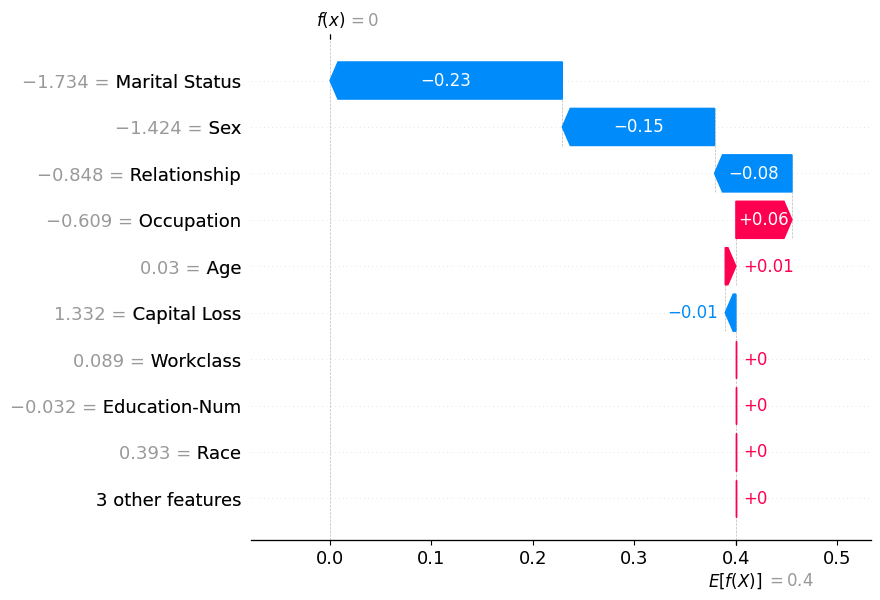

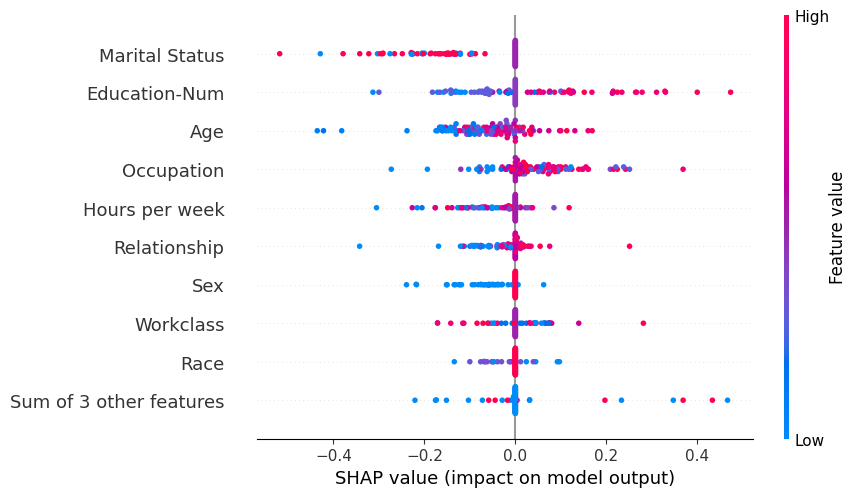

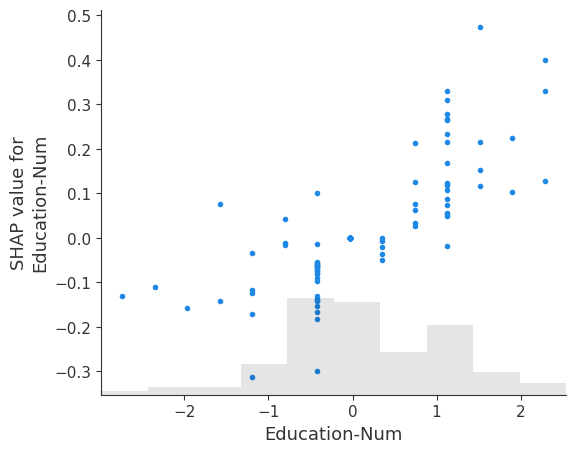

In [ ]:
import warnings

import matplotlib.pyplot as plt
import pandas as pd
import shap
import sklearn

X, y = shap.datasets.adult()
# X["Occupation"] *= 1000  # to show the impact of feature scale on KNN predictions
# It is important to note that Occupation is the dominant feature in the 1000 predictions
# we explain. This is because it has larger variations # in value than the other features
# and so it impacts the k-nearest neighbors calculations more.

X_train, X_valid, y_train, y_valid = sklearn.model_selection.train_test_split(
    X, y, test_size=0.2, random_state=7
)

# normalize data
dtypes = list(zip(X_train.dtypes.index, map(str, X_train.dtypes)))
X_train_norm = X_train.copy()
X_valid_norm = X_valid.copy()
for k, dtype in dtypes:
    m = X_train[k].mean()
    s = X_train[k].std()
    X_train_norm[k] -= m
    X_train_norm[k] /= s

    X_valid_norm[k] -= m
    X_valid_norm[k] /= s

knn = sklearn.neighbors.KNeighborsClassifier()
# knn.fit(X_train, y_train)
knn.fit(X_train_norm, y_train)


def f(x):
    with warnings.catch_warnings(action="ignore"):
        return knn.predict_proba(x)[:, 1]


# med = X_train.median().values.reshape((1, X_train.shape[1]))
med = X_train_norm.median().values.reshape((1, X_train_norm.shape[1]))

explainer = shap.Explainer(f, med)
# shap_values = explainer(X_valid.iloc[0:1000, :])
shap_values = explainer(X_valid_norm.iloc[0:100, :])

X_display, y_display = shap.datasets.adult(display=True)

shap.plots.waterfall(shap_values[0])
plt.show()
shap.plots.beeswarm(shap_values)
plt.show()
shap.plots.scatter(shap_values[:, "Education-Num"])
plt.show()


reversible normalization

PermutationExplainer explainer: 101it [00:26,  2.35it/s]                         


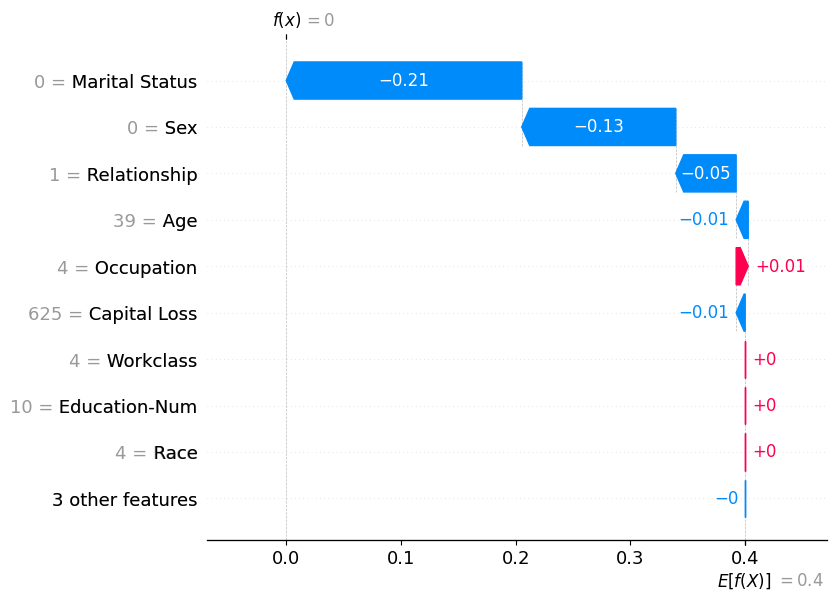

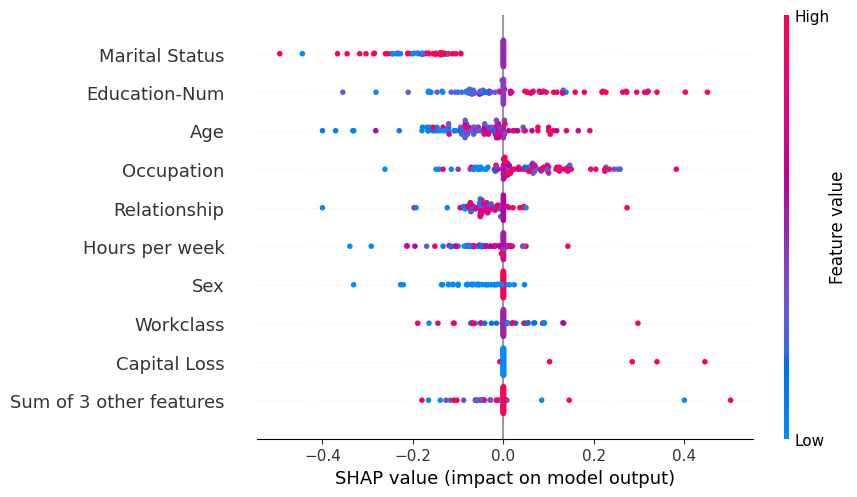

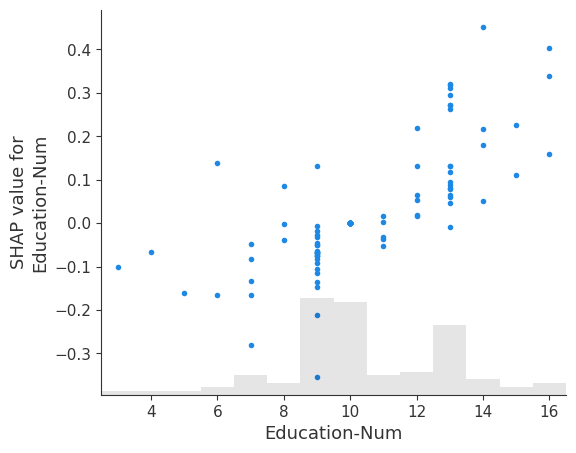

In [ ]:
import warnings

import matplotlib.pyplot as plt
import pandas as pd
import shap
import sklearn
from sklearn.preprocessing import StandardScaler

X, y = shap.datasets.adult()
# X["Occupation"] *= 1000  # to show the impact of feature scale on KNN predictions
# It is important to note that Occupation is the dominant feature in the 1000 predictions
# we explain. This is because it has larger variations # in value than the other features
# and so it impacts the k-nearest neighbors calculations more.

X_train, X_valid, y_train, y_valid = sklearn.model_selection.train_test_split(
    X, y, test_size=0.2, random_state=7
)

# normalize data
# Initialize the scaler
scaler = StandardScaler()
# Fit and transform the train data
scaler.fit(X_train)
X_train_norm = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
# trasform the valid data on train data
X_valid_norm = pd.DataFrame(scaler.transform(X_valid), columns=X_valid.columns)

knn = sklearn.neighbors.KNeighborsClassifier()
# knn.fit(X_train, y_train)
knn.fit(X_train_norm, y_train)


def f(x):
    # ignore warnings
    with warnings.catch_warnings(action="ignore"):
        # use scaler to normalize original input value
        x_norm = scaler.transform(x)
        return knn.predict_proba(x_norm)[:, 1]


med = X_train.median().values.reshape((1, X_train.shape[1]))

explainer = shap.Explainer(f, med)
shap_values = explainer(X_valid.iloc[0:100, :])

X_display, y_display = shap.datasets.adult(display=True)

shap.plots.waterfall(shap_values[0])
plt.show()
shap.plots.beeswarm(shap_values)
plt.show()
shap.plots.scatter(shap_values[:, "Education-Num"])
plt.show()


In [24]:
X_train

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
12011,51.0,4,10.0,0,6,0,4,0,0.0,0.0,40.0,21
23599,51.0,1,14.0,6,12,1,4,1,0.0,0.0,50.0,8
23603,21.0,4,11.0,4,3,3,2,1,0.0,0.0,40.0,39
6163,25.0,4,10.0,4,12,3,4,1,0.0,0.0,24.0,39
14883,48.0,4,13.0,0,1,3,4,1,0.0,0.0,38.0,39
...,...,...,...,...,...,...,...,...,...,...,...,...
5699,23.0,4,9.0,4,12,0,4,1,0.0,0.0,40.0,39
10742,37.0,4,9.0,2,7,4,4,1,0.0,0.0,40.0,39
16921,27.0,6,5.0,2,3,4,4,1,0.0,0.0,40.0,39
25796,46.0,4,16.0,2,10,4,4,1,0.0,2415.0,55.0,39


In [25]:
X_train_norm

array([[ 0.90806053,  0.08861723, -0.03210487, ..., -0.21738337,
        -0.03268185, -2.00485891],
       [ 0.90806053, -1.97482283,  1.51510634, ..., -0.21738337,
         0.77423463, -3.66349983],
       [-1.28769219,  0.08861723,  0.35469793, ..., -0.21738337,
        -0.03268185,  0.29172084],
       ...,
       [-0.84854165,  1.46424393, -1.96611888, ..., -0.21738337,
        -0.03268185,  0.29172084],
       [ 0.54210174,  0.08861723,  2.28871194, ...,  5.77112327,
         1.17769287,  0.29172084],
       [ 1.20082756,  0.08861723, -0.03210487, ..., -0.21738337,
        -0.03268185,  0.29172084]])

In [15]:
type(X)

pandas.core.frame.DataFrame

In [19]:
med

array([[-0.11662172,  0.08861553, -0.03210409, -0.40690318,  0.1013179 ,
         0.28900132,  0.39287005,  0.70211097, -0.1450927 , -0.21737921,
        -0.03268124,  0.29171524]])

In [20]:
shap_values[0]

.values =
array([ 0.01315789,  0.        ,  0.        , -0.22105263,  0.01842105,
       -0.07368421,  0.        , -0.13157895,  0.        , -0.00526316,
        0.        ,  0.        ])

.base_values =
0.4

.data =
array([ 0.02975899,  0.08861553, -0.03210409, -1.73401943, -0.60863422,
       -0.84814465,  0.39287005, -1.42422161, -0.1450927 ,  1.33241165,
       -0.03268124,  0.29171524])

In [21]:
explainer